<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Attribution.png" width="400">

<h1 align="left">Multi-investment Attribution: Distinguish the Effects of Multiple Outreach Efforts</h1>

A startup that sells software would like to know whether its multiple outreach efforts were successful in attracting new customers or boosting consumption among existing customers. They would also like to distinguish the effects of several incentives on different kinds of customers. In other words, they would like to learn the **heterogeneous treatment effect** of each investment on customers' software usage. 

In an ideal world, the startup would run several randomized experiments where each customer would receive a random assortment of investments. However, this can be logistically prohibitive or strategically unsound: the startup might not have the resources to design such experiments or they might not want to risk losing out on big opportunities due to lack of incentives.

In this customer scenario walkthrough, we show how tools from the [EconML](https://aka.ms/econml) and [DoWhy](https://github.com/microsoft/dowhy) libraries can use historical investment data to learn the effects of multiple investments.

### Summary

1. [Background](#Background)
2. [Data](#Data)
3. [Create Causal Model and Identify Causal Effect with DoWhy](#Create-Causal-Model-and-Identify-Causal-Effect-with-DoWhy)
4. [Get Causal Effects with EconML](#Get-Causal-Effects-with-EconML)
5. [Understand Treatment Effects with EconML](#Understand-Treatment-Effects-with-EconML)
6. [Make Policy Decisions with EconML](#Make-Policy-Decisions-with-EconML)
7. [Test Estimate Robustness with DoWhy](#Test-Estimate-Robustness-with-DoWhy)
    1. [Add Random Common Cause](#Add-Random-Common-Cause)
    2. [Add Unobserved Common Cause](#Add-Unobserved-Common-Cause)
    3. [Replace Treatment with a Random (Placebo) Variable](#Replace-Treatment-with-a-Random-(Placebo)-Variable)
    4. [Remove a Random Subset of the Data](#Remove-a-Random-Subset-of-the-Data)
8. [Conclusions](#Conclusions)

# Background

<img src="https://get.pxhere.com/photo/update-software-upgrade-laptop-computer-install-program-screen-system-repair-data-development-electronic-load-pc-process-progress-support-technical-load-1565823.jpg" width="400">

In this scenario, a startup that sells software provides two types of incentives to its customers: technical support and discounts. A customer might be given one, both or none of these incentives. 

The startup has historical data on these two investments for 2,000 customers, as well as how much revenue these customers generated in the year after the investments were made. They would like to use this data to learn the optimal incentive policy for each existing or new customer in order to maximize the return on investment (ROI).

The startup faces two challenges: 1) the dataset is biased because historically the larger customers received the most incentives and 2) the observed outcome combines effects from two different investments. Thus, they need a causal model that can accommodate multiple concurrent interventions. 

**Solution:** 
The EconML and DoWhy libraries complement each other in providing a complete solution. On one hand, the DoWhy library can help [build a causal model, identify the causal effect](#Create-Causal-Model-and-Identify-Causal-Effect-with-DoWhy) and [test causal assumptions](#Test-Estimate-Robustness-with-DoWhy). 

On the other hand, EconML's `Doubly Robust Learner` estimator can [jointly estimates the effects of multiple discrete treatments](#Get-Causal-Effects-with-EconML). The model uses flexible functions of observed customer features to filter out spurious correlations in existing data and deliver the causal effect of each intervention on revenue.


Furthermore, EconML provides users tools to [understand causal effects](#Understand-Treatment-Effects-with-EconML) and [make causal policy decisions](#Make-Policy-Decisions-with-EconML).

In [1]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from xgboost import XGBRegressor, XGBClassifier

# EconML imports
from econml.drlearner import LinearDRLearner

# DoWhy imports 
import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data

The data* contains ~2,000 customers and is comprised of:

* Customer features: details about the industry, size, revenue, and technology profile of each customer.
* Interventions: information about which incentive was given to a customer.
* Outcome: the amount of product the customer bought in the year after the incentives were given.

Feature Name | Type | Details 
:--- |:--- |:--- 
**Global Flag** | W | whether the customer has global offices
**Major Flag** | W | whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or SMB - Small Medium Business)
**SMC Flag** | W | whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)
**Commercial Flag** | W | whether the customer's business is commercial (as opposed to public secor)
**IT Spend** | W | \\$ spent on IT-related purchases 
**Employee Count** | W | number of employees
**PC Count** | W | number of PCs used by the customer
**Size** | X | customer's size given by their yearly total revenue 
**Tech Support** | T | whether the customer received tech support (binary)
**Discount** | T | whether the customer was given a discount (binary)
**Revenue** | Y | \\$ Revenue from customer given by the amount of software purchased

**To protect the privacy of the startup's customers, the data used in this scenario is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*

In [2]:
# Import the sample multi-attribution data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
multi_data = pd.read_csv(file_url)

In [3]:
# Data sample
multi_data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


In [4]:
# Define estimator inputs
T_bin = multi_data[
    ["Tech Support", "Discount"]
]  # multiple interventions, or treatments
Y = multi_data["Revenue"]  # amount of product purchased, or outcome
X = multi_data[["Size"]]  # heterogeneity feature
W = multi_data.drop(
    columns=["Tech Support", "Discount", "Revenue", "Size"]
)  # controls

We investigate below whether the number of investments given is correlated with the size of the customer. We note that the average customer size is larger for more incentives given. 

In [5]:
# Average customer size per incentive combination
multi_data[["Size", "Tech Support", "Discount"]].groupby(
    by=["Tech Support", "Discount"], as_index=False
).mean().astype(int)

,Tech Support,Discount,Size
0,0,0,70943
1,0,1,96466
2,1,0,108978
3,1,1,171466


The data was generated using the following underlying treatment effect function:

$$
\text{treatment_effect(Size)} = (5,000 + 2\% \cdot \text{Size}) \cdot I_\text{Tech Support} + (5\% \cdot \text{Size}) \cdot I_\text{Discount}
$$

Therefore, the treatment effect depends on the customer's size as follows: tech support provides an consumption boost of \$5,000 + 2\% Size and a discount provides an consumption boost of 5\% Size.**This is the relationship we seek to learn from the data.**

In [6]:
# Define underlying treatment effect function
TE_fn = lambda X: np.hstack([5000 + 2 / 100 * X, 5 / 100 * X])
true_TE = TE_fn(X)

# Define true coefficients for the three treatments
# The third coefficient is just the sum of the first two since we assume an additive effect
true_coefs = [2 / 100, 5 / 100, 7 / 100]
true_intercepts = [5000, 0, 5000]
treatment_names = ["Tech Support", "Discount", "Tech Support & Discount"]

# Create Causal Model and Identify Causal Effect with DoWhy

We define the causal assumptions of the multi-intervention setting with DoWhy. For example, we can include features we believe influence both the treatments* and the outcome (`common_causes`) and features we think will influence the heterogeneity of the effect (`effect_modifiers`). With these assumptions defined, DoWhy can identify the causal effect for us.

*The `DoWhy` and `EconML` estimators require multiple binary treatments to be given as a list of discrete treatments $T$ that correspond to different types of interventions. Thus, we first map the binary interventions tech support and discount into one categorical variable:*

Tech support| Discount| Treatment encoding| Details
:--- |:--- |:--- |:---
0 | 0 | 0 | no incentive
1 | 0 | 1 | tech support only
0 | 1 | 2 | discount only
1 | 1 | 3 | both incentives

In [7]:
# Transform T to one-dimensional array with consecutive integer encoding
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))

In [8]:
T = np.apply_along_axis(treat_map, 1, T_bin).astype(int)
multi_data["discrete_T"] = T

In [9]:
model = CausalModel(
    data=multi_data, 
    treatment='discrete_T', 
    outcome='Revenue', 
    common_causes=W.columns.to_list(),
    effect_modifiers=X.columns.to_list()
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['discrete_T'] on outcome ['Revenue']


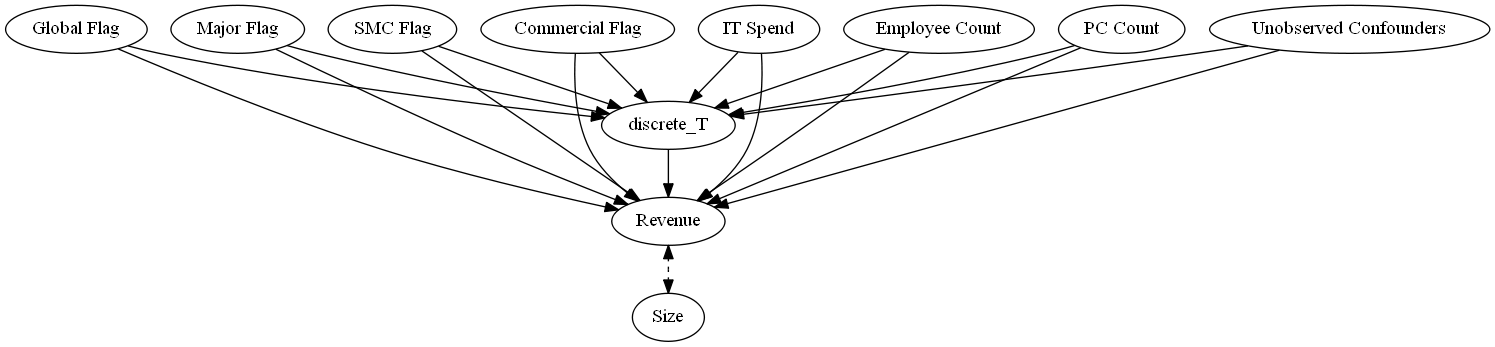

In [10]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(model._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    model.view_model() 

In [11]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
      d                                                                       
─────────────(Expectation(Revenue|PC Count,Global Flag,Employee Count,SMC Flag
d[discrete_T]                                                                 

                                      
,Commercial Flag,IT Spend,Major Flag))
                                      
Estimand assumption 1, Unconfoundedness: If U→{discrete_T} and U→Revenue then P(Revenue|discrete_T,PC Count,Global Flag,Employee Count,SMC Flag,Commercial Flag,IT Spend,Major Flag,U) = P(Revenue|discrete_T,PC Count,Global Flag,Employee Count,SMC Flag,Commercial Flag,IT Spend,Major Flag)

### Estimand : 2
Estimand name: iv
No such variable found!



# Get Causal Effects with EconML

To get causal effects, we use EconML's `LinearDRLearner`* estimator. The estimator takes as input the outcome of interest $Y$ (amount of product purchased), a discrete treatment $T$ (interventions given), heterogeneity features $X$ (here, customer's size) and controls $W$ (all other customer features).

The LinearDRLearner also requires two auxiliary models to model the relationships $T\sim (W, X)$ (`model_propensity`) and $Y \sim (W, X)$(`model_regression`). These can be generic, flexible classification and regression models, respectively.  

**This estimator assumes a linear relationship between the treatment effect and a transformation of the features $X$ (e.g. a polynomial basis expansion). For more generic forms of the treatment effect, see the `DRLearner` estimator.*

In [12]:
test_customers = X.iloc[:1000].values
drlearner_estimate = model.estimate_effect(identified_estimand,
                                      method_name="backdoor.econml.drlearner.LinearDRLearner",
                                      target_units = test_customers,
                                      treatment_value = 1,
                                      method_params={
                                          "init_params":{'model_regression': XGBRegressor(), 
                                                         'model_propensity': XGBClassifier(objective="multi:softmax"),
                                                         'random_state': 1,
                                                        },
                                          "fit_params":{}})
print(drlearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size
Target units: 

## Estimate
Mean value: 7639.419625621788



When training the model, `DoWhy` automatically calculates the average treatment effect (ATE) on a test sample. In the case above, we asked that `DoWhy` calculate the ATE for $T=1$ which corresponds to a customer getting tech support only. Let's see how this compares to the true ATE:

In [13]:
true_customer_TE = TE_fn(test_customers)
print("True ATE on test data: ", true_customer_TE[:, 0].mean())

True ATE on test data:  7275.564040000001


We can see that the two values are close which is a good starting point for our algorithm. In a future section, we see how the calculated heterogeneous treatment effects compare with the true ones. 

# Understand Treatment Effects with EconML

We can obtain a summary of the coefficient values as well as confidence intervals by calling the `summary` function on the fitted model for each treatment.

In [14]:
econml_model = drlearner_estimate._estimator_object

In [15]:
for i in range(econml_model._d_t[0]):
    print(f"Investment: {treatment_names[i]}")
    print(f"True treatment effect: {true_intercepts[i]} + {true_coefs[i]}*Size")
    display(econml_model.summary(T=i + 1, feat_name=["Size"]))

Investment: Tech Support
True treatment effect: 5000 + 0.02*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.02,0.012,1.723,0.085,0.001,0.04
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5328.984,847.687,6.287,0.0,3934.664,6723.304


Investment: Discount
True treatment effect: 0 + 0.05*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.052,0.012,4.364,0.0,0.032,0.071
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,348.215,850.082,0.41,0.682,-1050.046,1746.475


Investment: Tech Support & Discount
True treatment effect: 5000 + 0.07*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.074,0.012,6.282,0.0,0.054,0.093
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,4893.262,852.439,5.74,0.0,3491.125,6295.398


From the summary panels, we see that the learned coefficients/intercepts are close to the true coefficients/intercepts and the p-values are small for most of these. 

We further use the `coef_, coef__interval` and the `intercept_, intercept__interval` methods to obtain the learned coefficient values and build confidence intervals. We compare the true and the learned coefficients through the plots below.

In [16]:
# Compare learned coefficients with true model coefficients
# Aggregate data
coef_indices = np.arange(econml_model._d_t[0])
coefs = np.hstack([econml_model.coef_(T=i) for i in 1 + coef_indices])
intercepts = np.hstack([econml_model.intercept_(T=i) for i in 1 + coef_indices])

# Calculate coefficient error bars for 90% confidence interval
coef_error = np.hstack([econml_model.coef__interval(T=i) for i in 1 + coef_indices])
coef_error[0, :] = coefs - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - coefs

# Calculate intercept error bars for 90% confidence interval
intercept_error = np.vstack(
    [econml_model.intercept__interval(T=i) for i in 1 + coef_indices]
).T
intercept_error[0, :] = intercepts - intercept_error[0, :]
intercept_error[1, :] = intercept_error[1, :] - intercepts

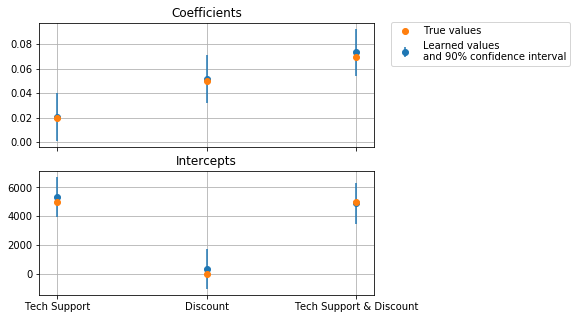

In [17]:
# Plot coefficients
plt.figure(figsize=(6, 5))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(
    coef_indices,
    coefs,
    coef_error,
    fmt="o",
    label="Learned values\nand 90% confidence interval",
)
plt.scatter(coef_indices, true_coefs, color="C1", label="True values", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients")
plt.legend(loc=(1.05, 0.65))
plt.grid()

# Plot intercepts
plt.subplot(2, 1, 2)
plt.errorbar(coef_indices, intercepts, intercept_error, fmt="o")
plt.scatter(coef_indices, true_intercepts, color="C1", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.title("Intercepts")
plt.grid()
plt.show()

# Make Policy Decisions with EconML

Investments such as tech support and discounts come with an associated cost. Thus, we would like to know what incentives to give to each customer to maximize the profit from their increased engagement. This is the **treatment policy**.

In this scenario, we define a cost function as follows:
* The cost of `tech support` scales with the number of PCs a customer has. You can imagine that if the software product needs tech support to be installed on each machine, there is a cost (\\$100 here) per machine.
* The cost of `discount` is a fixed \\$7,000. Think of this as giving the customer the first \\$7,000 worth of product for free.
* The cost of `tech support` and `discount` is the sum of the cost of each of these. Note that this might not be the case in every business application: it is possible that managing multiple incentive programs can add overhead. 

In [18]:
# Define cost function
def cost_fn(multi_data):
    t1_cost = multi_data[["PC Count"]].values * 100
    t2_cost = np.ones((multi_data.shape[0], 1)) * 7000
    return np.hstack([t1_cost, t2_cost, t1_cost + t2_cost])

We use the model's `const_marginal_effect` method to find the counterfactual treatment effect for each possible treatment. We then subtract the treatment cost and choose the treatment which the highest return. That is the recommended policy.

In [19]:
# Get roi for each customer and possible treatment
potential_roi = econml_model.const_marginal_effect(X=X.values) - cost_fn(multi_data)
# Add a column of 0s for no treatment
potential_roi = np.hstack([np.zeros(X.shape), potential_roi])

In [20]:
all_treatments = np.array(["None"] + treatment_names)
recommended_T = np.argmax(potential_roi, axis=1)

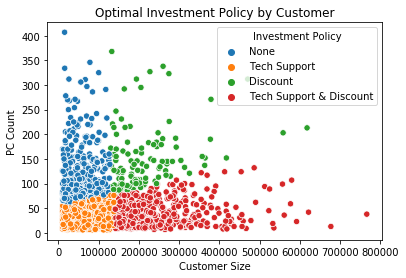

In [21]:
ax1 = sns.scatterplot(
    x=X.values.flatten(),
    y=multi_data["PC Count"].values,
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    cmap="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="Customer Size",
    ylabel="PC Count",
    title="Optimal Investment Policy by Customer",
)
plt.show()

We compare different policies: the optimal policy we learned, the current policy, and the policy under which each customer is given all incentives. We note that the optimal policy has a much higher ROI than the alternatives. 

In [22]:
roi_current = potential_roi[np.arange(X.shape[1]), T].sum()
roi_optimal = potential_roi[np.arange(X.shape[1]), recommended_T].sum()
roi_bothT = potential_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - econml_model.effect(X=X.values, T1=T)).sum()

In [23]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,9.112910e+06,59.8
1,Current,6.805551e+06,44.7
2,All Investments,9.647234e+05,6.3


# Test Estimate Robustness with DoWhy

### Add Random Common Cause

How robust are our estimates to adding an uncorrelated confounder? We use DoWhy to test this!

In [24]:
res_random = model.refute_estimate(
    identified_estimand, drlearner_estimate, method_name="random_common_cause"
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+w_random+Size | Size


[13:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Refute: Add a Random Common Cause
Estimated effect:7639.419625621788
New effect:7761.4054198066515



### Add Unobserved Common Cause

How robust are our estimates to unobserved confounders? Since we assume unconfoundedness, adding an unobserved confounder might bias the estimates. We use DoWhy to show this!

In [25]:
res_unobserved = model.refute_estimate(
    identified_estimand, drlearner_estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.3, effect_strength_on_outcome=0.5)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Refute: Add an Unobserved Common Cause
Estimated effect:7639.419625621788
New effect:2206.663523774475



### Replace Treatment with a Random (Placebo) Variable

What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be close to $0$. We use DoWhy to investigate!

In [26]:
res_placebo = model.refute_estimate(
    identified_estimand, drlearner_estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=5
)
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 5 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~placebo+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~placebo+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~placebo+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~placebo+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~placebo+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:7639.419625621788
New effect:200.73694452603883
p value:0.18699298301803485



While the "New effect" is not zero, the p-value is greater than 0.05 which means that we cannot reject the null hypothesis that $0$ is under the average treatment effect distribution. Increasing `num_simulations` should produce a "New effect" closer to $0$. 

### Remove a Random Subset of the Data

Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

In [27]:
# Removing a random subset of the data
res_subset = model.refute_estimate(
    identified_estimand, drlearner_estimate,
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=5)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 1600.0 each
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Revenue~discrete_T+PC Count+Global Flag+Employee Count+SMC Flag+Commercial Flag+IT Spend+Major Flag+Size | Size


[13:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


[13:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Refute: Use a subset of data
Estimated effect:7639.419625621788
New effect:9181.903603002269
p value:0.11559361452527789



The "New effect" is close to the estimated effect from the original dataset and the p-value is greater than 0.05. Thus, we cannot reject the null hypothesis that the estimated effect is under the average treatment effect distribution. 

# Conclusions

In this notebook, we have demonstrated the power of using `EconML` and `DoWhy` to:

* Learn the effects of multiple concurrent interventions
* Interpret the resulting individual-level treatment effects
* Build investment policies around the learned effects
* Test causal assumptions and investigate the robustness of the estimates

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/microsoft/EconML) or our [documentation](https://econml.azurewebsites.net/). 

To learn more about what DoWhy can do for you, visit the [GitHub page](https://github.com/microsoft/dowhy) or [documentation](https://microsoft.github.io/dowhy/index.html).